In [8]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
import lightgbm as lgb
import pandas as pd
import numpy as np
import warnings
import gc

from common import data_load_home_credit, find_optimal_cutoff, plot_confusion_matrix, plot_auc

warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [15]:
train, test = data_load_home_credit('/media/ismaeel/Work/msds19029_thesis/dataset/home_with_missing.csv')

In [3]:
def kfold_lightgbm_sklearn(train, test, categorical_feature = None):
    
    print("Train/valid shape: {}, test shape: {}".format(train.shape, test.shape))
    del_features = ['TARGET', 'SK_ID_CURR', 'SK_ID_BUREAU', 'SK_ID_PREV', 'index', 'level_0']
    predictors = list(filter(lambda v: v not in del_features, train.columns))

    if not STRATIFIED_KFOLD:
        folds = KFold(n_splits= NUM_FOLDS, shuffle=True, random_state= RANDOM_SEED)
    else:
        folds = StratifiedKFold(n_splits= NUM_FOLDS, shuffle=True, random_state= RANDOM_SEED)

    oof_preds = np.zeros(train.shape[0])
    eval_results = dict()

    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train[predictors], train['TARGET'])):
        
        train_x, train_y = train[predictors].iloc[train_idx], train['TARGET'].iloc[train_idx]
        valid_x, valid_y = train[predictors].iloc[valid_idx], train['TARGET'].iloc[valid_idx]

        params = {'random_state': RANDOM_SEED, 'nthread': NUM_THREADS}
        clf = LGBMClassifier(**{**params, **LIGHTGBM_PARAMS})
        if not categorical_feature:
            clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)],
                    eval_metric='auc', verbose=400, early_stopping_rounds= EARLY_STOPPING)
        else:
            clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)],
                    eval_metric='auc', verbose=400, early_stopping_rounds=EARLY_STOPPING,
                    feature_name= list(train[predictors].columns), categorical_feature= categorical_feature)
            
        clf.booster_.save_model('/media/ismaeel/Work/ThesisandProjects/msds19029_thesis/saved_models/LGBM.txt')
        oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
        
        eval_results['train_{}'.format(n_fold+1)]  = clf.evals_result_['training']['auc']
        eval_results['valid_{}'.format(n_fold+1)] = clf.evals_result_['valid_1']['auc']

        print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
        del clf, train_x, train_y, valid_x, valid_y
        gc.collect()

    print('Full AUC score %.6f' % roc_auc_score(train['TARGET'], oof_preds))
    
    return clf

In [6]:
STRATIFIED_KFOLD = False
RANDOM_SEED = 737851
NUM_FOLDS = 10
EARLY_STOPPING = 100
NUM_THREADS = 4

LIGHTGBM_PARAMS = {
    'boosting_type': 'goss',
    'n_estimators': 10000,
    'learning_rate': 0.005134,
    'num_leaves': 54,
    'max_depth': 10,
    'subsample_for_bin': 240000,
    'reg_alpha': 0.436193,
    'reg_lambda': 0.479169,
    'colsample_bytree': 0.508716,
    'min_split_gain': 0.024766,
    'subsample': 1,
    'is_unbalance': False,
    'silent':-1,
    'verbose':-1
}

In [7]:
lgbm_categorical_feat = [
    'CODE_GENDER', 'FLAG_OWN_CAR', 'NAME_CONTRACT_TYPE', 'NAME_EDUCATION_TYPE',
    'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'NAME_INCOME_TYPE', 'OCCUPATION_TYPE',
    'ORGANIZATION_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'NAME_TYPE_SUITE', 'WALLSMATERIAL_MODE']
clf = kfold_lightgbm_sklearn(train, test, lgbm_categorical_feat)

Train/valid shape: (239818, 256), test shape: (26647, 256)


/media/ismaeel/Work/ThesisandProjects/msds19029_thesis/env/lib/python3.8/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/media/ismaeel/Work/ThesisandProjects/msds19029_thesis/env/lib/python3.8/site-packages/lightgbm/basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['CODE_GENDER', 'FLAG_OWN_CAR', 'NAME_CONTRACT_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'NAME_INCOME_TYPE', 'NAME_TYPE_SUITE', 'OCCUPATION_TYPE', 'ORGANIZATION_TYPE', 'WALLSMATERIAL_MODE', 'WEEKDAY_APPR_PROCESS_START']
  _log_warning('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1


/media/ismaeel/Work/ThesisandProjects/msds19029_thesis/env/lib/python3.8/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/media/ismaeel/Work/ThesisandProjects/msds19029_thesis/env/lib/python3.8/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 100 rounds
[400]	training's auc: 0.795313	training's binary_logloss: 0.240306	valid_1's auc: 0.761141	valid_1's binary_logloss: 0.24855
[800]	training's auc: 0.822414	training's binary_logloss: 0.228423	valid_1's auc: 0.770462	valid_1's binary_logloss: 0.243855
[1200]	training's auc: 0.842029	training's binary_logloss: 0.220317	valid_1's auc: 0.774395	valid_1's binary_logloss: 0.242229
[1600]	training's auc: 0.858933	training's binary_logloss: 0.213425	valid_1's auc: 0.776516	valid_1's binary_logloss: 0.241442
[2000]	training's auc: 0.873491	training's binary_logloss: 0.207336	valid_1's auc: 0.777595	valid_1's binary_logloss: 0.241119
Early stopping, best iteration is:
[2069]	training's auc: 0.875761	training's binary_logloss: 0.206351	valid_1's auc: 0.777725	valid_1's binary_logloss: 0.241075
Fold  1 AUC : 0.777725


/media/ismaeel/Work/ThesisandProjects/msds19029_thesis/env/lib/python3.8/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/media/ismaeel/Work/ThesisandProjects/msds19029_thesis/env/lib/python3.8/site-packages/lightgbm/basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['CODE_GENDER', 'FLAG_OWN_CAR', 'NAME_CONTRACT_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'NAME_INCOME_TYPE', 'NAME_TYPE_SUITE', 'OCCUPATION_TYPE', 'ORGANIZATION_TYPE', 'WALLSMATERIAL_MODE', 'WEEKDAY_APPR_PROCESS_START']
  _log_warning('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1


/media/ismaeel/Work/ThesisandProjects/msds19029_thesis/env/lib/python3.8/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/media/ismaeel/Work/ThesisandProjects/msds19029_thesis/env/lib/python3.8/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 100 rounds
[400]	training's auc: 0.794125	training's binary_logloss: 0.240459	valid_1's auc: 0.772825	valid_1's binary_logloss: 0.247282
[800]	training's auc: 0.82149	training's binary_logloss: 0.228652	valid_1's auc: 0.784019	valid_1's binary_logloss: 0.241647
[1200]	training's auc: 0.841234	training's binary_logloss: 0.220585	valid_1's auc: 0.788124	valid_1's binary_logloss: 0.239711
[1600]	training's auc: 0.857966	training's binary_logloss: 0.213766	valid_1's auc: 0.79034	valid_1's binary_logloss: 0.238783
[2000]	training's auc: 0.872757	training's binary_logloss: 0.207646	valid_1's auc: 0.791475	valid_1's binary_logloss: 0.238286
[2400]	training's auc: 0.885892	training's binary_logloss: 0.202006	valid_1's auc: 0.792074	valid_1's binary_logloss: 0.238045
[2800]	training's auc: 0.897526	training's binary_logloss: 0.196786	valid_1's auc: 0.792585	valid_1's binary_logloss: 0.237852
Early stopping, best iteration is:
[3066]	training's 

/media/ismaeel/Work/ThesisandProjects/msds19029_thesis/env/lib/python3.8/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/media/ismaeel/Work/ThesisandProjects/msds19029_thesis/env/lib/python3.8/site-packages/lightgbm/basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['CODE_GENDER', 'FLAG_OWN_CAR', 'NAME_CONTRACT_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'NAME_INCOME_TYPE', 'NAME_TYPE_SUITE', 'OCCUPATION_TYPE', 'ORGANIZATION_TYPE', 'WALLSMATERIAL_MODE', 'WEEKDAY_APPR_PROCESS_START']
  _log_warning('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1


/media/ismaeel/Work/ThesisandProjects/msds19029_thesis/env/lib/python3.8/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/media/ismaeel/Work/ThesisandProjects/msds19029_thesis/env/lib/python3.8/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 100 rounds
[400]	training's auc: 0.794917	training's binary_logloss: 0.240337	valid_1's auc: 0.767199	valid_1's binary_logloss: 0.24794
[800]	training's auc: 0.822025	training's binary_logloss: 0.228508	valid_1's auc: 0.777788	valid_1's binary_logloss: 0.242734
[1200]	training's auc: 0.841557	training's binary_logloss: 0.220425	valid_1's auc: 0.782277	valid_1's binary_logloss: 0.240876
[1600]	training's auc: 0.858185	training's binary_logloss: 0.213651	valid_1's auc: 0.78425	valid_1's binary_logloss: 0.240049
[2000]	training's auc: 0.87285	training's binary_logloss: 0.207531	valid_1's auc: 0.785481	valid_1's binary_logloss: 0.23957
Early stopping, best iteration is:
[2130]	training's auc: 0.877219	training's binary_logloss: 0.205682	valid_1's auc: 0.785624	valid_1's binary_logloss: 0.239494
Fold  3 AUC : 0.785624


/media/ismaeel/Work/ThesisandProjects/msds19029_thesis/env/lib/python3.8/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/media/ismaeel/Work/ThesisandProjects/msds19029_thesis/env/lib/python3.8/site-packages/lightgbm/basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['CODE_GENDER', 'FLAG_OWN_CAR', 'NAME_CONTRACT_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'NAME_INCOME_TYPE', 'NAME_TYPE_SUITE', 'OCCUPATION_TYPE', 'ORGANIZATION_TYPE', 'WALLSMATERIAL_MODE', 'WEEKDAY_APPR_PROCESS_START']
  _log_warning('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1


/media/ismaeel/Work/ThesisandProjects/msds19029_thesis/env/lib/python3.8/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/media/ismaeel/Work/ThesisandProjects/msds19029_thesis/env/lib/python3.8/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 100 rounds
[400]	training's auc: 0.795458	training's binary_logloss: 0.240079	valid_1's auc: 0.755693	valid_1's binary_logloss: 0.250136
[800]	training's auc: 0.822493	training's binary_logloss: 0.228236	valid_1's auc: 0.766347	valid_1's binary_logloss: 0.245698
[1200]	training's auc: 0.842311	training's binary_logloss: 0.220085	valid_1's auc: 0.770555	valid_1's binary_logloss: 0.244237
[1600]	training's auc: 0.858765	training's binary_logloss: 0.213271	valid_1's auc: 0.772625	valid_1's binary_logloss: 0.243516
[2000]	training's auc: 0.873345	training's binary_logloss: 0.207193	valid_1's auc: 0.773626	valid_1's binary_logloss: 0.24322
[2400]	training's auc: 0.886406	training's binary_logloss: 0.201596	valid_1's auc: 0.774167	valid_1's binary_logloss: 0.243061
Early stopping, best iteration is:
[2559]	training's auc: 0.891162	training's binary_logloss: 0.199459	valid_1's auc: 0.774421	valid_1's binary_logloss: 0.242978
Fold  4 AUC : 0.7

/media/ismaeel/Work/ThesisandProjects/msds19029_thesis/env/lib/python3.8/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/media/ismaeel/Work/ThesisandProjects/msds19029_thesis/env/lib/python3.8/site-packages/lightgbm/basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['CODE_GENDER', 'FLAG_OWN_CAR', 'NAME_CONTRACT_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'NAME_INCOME_TYPE', 'NAME_TYPE_SUITE', 'OCCUPATION_TYPE', 'ORGANIZATION_TYPE', 'WALLSMATERIAL_MODE', 'WEEKDAY_APPR_PROCESS_START']
  _log_warning('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1


/media/ismaeel/Work/ThesisandProjects/msds19029_thesis/env/lib/python3.8/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/media/ismaeel/Work/ThesisandProjects/msds19029_thesis/env/lib/python3.8/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 100 rounds
[400]	training's auc: 0.794875	training's binary_logloss: 0.240533	valid_1's auc: 0.760566	valid_1's binary_logloss: 0.246041
[800]	training's auc: 0.821876	training's binary_logloss: 0.228732	valid_1's auc: 0.772493	valid_1's binary_logloss: 0.24111
[1200]	training's auc: 0.841606	training's binary_logloss: 0.220606	valid_1's auc: 0.777197	valid_1's binary_logloss: 0.23939
[1600]	training's auc: 0.8583	training's binary_logloss: 0.213797	valid_1's auc: 0.779495	valid_1's binary_logloss: 0.238529
[2000]	training's auc: 0.872822	training's binary_logloss: 0.2077	valid_1's auc: 0.780717	valid_1's binary_logloss: 0.238108
[2400]	training's auc: 0.885633	training's binary_logloss: 0.202133	valid_1's auc: 0.781379	valid_1's binary_logloss: 0.237877
[2800]	training's auc: 0.897226	training's binary_logloss: 0.196896	valid_1's auc: 0.7818	valid_1's binary_logloss: 0.237733
Early stopping, best iteration is:
[2732]	training's auc: 0

/media/ismaeel/Work/ThesisandProjects/msds19029_thesis/env/lib/python3.8/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/media/ismaeel/Work/ThesisandProjects/msds19029_thesis/env/lib/python3.8/site-packages/lightgbm/basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['CODE_GENDER', 'FLAG_OWN_CAR', 'NAME_CONTRACT_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'NAME_INCOME_TYPE', 'NAME_TYPE_SUITE', 'OCCUPATION_TYPE', 'ORGANIZATION_TYPE', 'WALLSMATERIAL_MODE', 'WEEKDAY_APPR_PROCESS_START']
  _log_warning('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1


/media/ismaeel/Work/ThesisandProjects/msds19029_thesis/env/lib/python3.8/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/media/ismaeel/Work/ThesisandProjects/msds19029_thesis/env/lib/python3.8/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 100 rounds
[400]	training's auc: 0.794724	training's binary_logloss: 0.240144	valid_1's auc: 0.76142	valid_1's binary_logloss: 0.250126
[800]	training's auc: 0.821882	training's binary_logloss: 0.228357	valid_1's auc: 0.774962	valid_1's binary_logloss: 0.244562
[1200]	training's auc: 0.841601	training's binary_logloss: 0.220232	valid_1's auc: 0.780856	valid_1's binary_logloss: 0.242423
[1600]	training's auc: 0.858168	training's binary_logloss: 0.213445	valid_1's auc: 0.783794	valid_1's binary_logloss: 0.241382
[2000]	training's auc: 0.872765	training's binary_logloss: 0.207348	valid_1's auc: 0.785457	valid_1's binary_logloss: 0.240781
[2400]	training's auc: 0.885929	training's binary_logloss: 0.201759	valid_1's auc: 0.786086	valid_1's binary_logloss: 0.240535
Early stopping, best iteration is:
[2626]	training's auc: 0.892512	training's binary_logloss: 0.198783	valid_1's auc: 0.786607	valid_1's binary_logloss: 0.240387
Fold  6 AUC : 0.7

/media/ismaeel/Work/ThesisandProjects/msds19029_thesis/env/lib/python3.8/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/media/ismaeel/Work/ThesisandProjects/msds19029_thesis/env/lib/python3.8/site-packages/lightgbm/basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['CODE_GENDER', 'FLAG_OWN_CAR', 'NAME_CONTRACT_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'NAME_INCOME_TYPE', 'NAME_TYPE_SUITE', 'OCCUPATION_TYPE', 'ORGANIZATION_TYPE', 'WALLSMATERIAL_MODE', 'WEEKDAY_APPR_PROCESS_START']
  _log_warning('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1


/media/ismaeel/Work/ThesisandProjects/msds19029_thesis/env/lib/python3.8/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/media/ismaeel/Work/ThesisandProjects/msds19029_thesis/env/lib/python3.8/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 100 rounds
[400]	training's auc: 0.794771	training's binary_logloss: 0.239828	valid_1's auc: 0.762776	valid_1's binary_logloss: 0.252732
[800]	training's auc: 0.821795	training's binary_logloss: 0.228071	valid_1's auc: 0.77446	valid_1's binary_logloss: 0.247434
[1200]	training's auc: 0.841482	training's binary_logloss: 0.22	valid_1's auc: 0.779622	valid_1's binary_logloss: 0.245468
[1600]	training's auc: 0.858154	training's binary_logloss: 0.213202	valid_1's auc: 0.782354	valid_1's binary_logloss: 0.244484
[2000]	training's auc: 0.872628	training's binary_logloss: 0.207125	valid_1's auc: 0.783569	valid_1's binary_logloss: 0.244056
[2400]	training's auc: 0.885327	training's binary_logloss: 0.201615	valid_1's auc: 0.784411	valid_1's binary_logloss: 0.243736
Early stopping, best iteration is:
[2564]	training's auc: 0.89029	training's binary_logloss: 0.199439	valid_1's auc: 0.784636	valid_1's binary_logloss: 0.24366
Fold  7 AUC : 0.784636


/media/ismaeel/Work/ThesisandProjects/msds19029_thesis/env/lib/python3.8/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/media/ismaeel/Work/ThesisandProjects/msds19029_thesis/env/lib/python3.8/site-packages/lightgbm/basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['CODE_GENDER', 'FLAG_OWN_CAR', 'NAME_CONTRACT_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'NAME_INCOME_TYPE', 'NAME_TYPE_SUITE', 'OCCUPATION_TYPE', 'ORGANIZATION_TYPE', 'WALLSMATERIAL_MODE', 'WEEKDAY_APPR_PROCESS_START']
  _log_warning('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1


/media/ismaeel/Work/ThesisandProjects/msds19029_thesis/env/lib/python3.8/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/media/ismaeel/Work/ThesisandProjects/msds19029_thesis/env/lib/python3.8/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 100 rounds
[400]	training's auc: 0.795048	training's binary_logloss: 0.240446	valid_1's auc: 0.765456	valid_1's binary_logloss: 0.246619
[800]	training's auc: 0.822142	training's binary_logloss: 0.228645	valid_1's auc: 0.777092	valid_1's binary_logloss: 0.241378
[1200]	training's auc: 0.841938	training's binary_logloss: 0.220528	valid_1's auc: 0.78222	valid_1's binary_logloss: 0.239366
[1600]	training's auc: 0.858362	training's binary_logloss: 0.213758	valid_1's auc: 0.784538	valid_1's binary_logloss: 0.238454
[2000]	training's auc: 0.873039	training's binary_logloss: 0.207686	valid_1's auc: 0.785941	valid_1's binary_logloss: 0.237954
[2400]	training's auc: 0.88606	training's binary_logloss: 0.202068	valid_1's auc: 0.786965	valid_1's binary_logloss: 0.237583
[2800]	training's auc: 0.897685	training's binary_logloss: 0.19683	valid_1's auc: 0.787338	valid_1's binary_logloss: 0.237396
[3200]	training's auc: 0.907969	training's binary_logl

/media/ismaeel/Work/ThesisandProjects/msds19029_thesis/env/lib/python3.8/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/media/ismaeel/Work/ThesisandProjects/msds19029_thesis/env/lib/python3.8/site-packages/lightgbm/basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['CODE_GENDER', 'FLAG_OWN_CAR', 'NAME_CONTRACT_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'NAME_INCOME_TYPE', 'NAME_TYPE_SUITE', 'OCCUPATION_TYPE', 'ORGANIZATION_TYPE', 'WALLSMATERIAL_MODE', 'WEEKDAY_APPR_PROCESS_START']
  _log_warning('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1


/media/ismaeel/Work/ThesisandProjects/msds19029_thesis/env/lib/python3.8/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/media/ismaeel/Work/ThesisandProjects/msds19029_thesis/env/lib/python3.8/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 100 rounds
[400]	training's auc: 0.794432	training's binary_logloss: 0.240396	valid_1's auc: 0.768072	valid_1's binary_logloss: 0.247636
[800]	training's auc: 0.822037	training's binary_logloss: 0.228488	valid_1's auc: 0.778116	valid_1's binary_logloss: 0.242806
[1200]	training's auc: 0.841453	training's binary_logloss: 0.220403	valid_1's auc: 0.781649	valid_1's binary_logloss: 0.24131
[1600]	training's auc: 0.858177	training's binary_logloss: 0.213588	valid_1's auc: 0.783369	valid_1's binary_logloss: 0.240654
[2000]	training's auc: 0.87262	training's binary_logloss: 0.20752	valid_1's auc: 0.78451	valid_1's binary_logloss: 0.240256
[2400]	training's auc: 0.885625	training's binary_logloss: 0.201925	valid_1's auc: 0.785006	valid_1's binary_logloss: 0.240094
Early stopping, best iteration is:
[2648]	training's auc: 0.892888	training's binary_logloss: 0.198677	valid_1's auc: 0.785204	valid_1's binary_logloss: 0.240032
Fold  9 AUC : 0.7852

/media/ismaeel/Work/ThesisandProjects/msds19029_thesis/env/lib/python3.8/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/media/ismaeel/Work/ThesisandProjects/msds19029_thesis/env/lib/python3.8/site-packages/lightgbm/basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['CODE_GENDER', 'FLAG_OWN_CAR', 'NAME_CONTRACT_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'NAME_INCOME_TYPE', 'NAME_TYPE_SUITE', 'OCCUPATION_TYPE', 'ORGANIZATION_TYPE', 'WALLSMATERIAL_MODE', 'WEEKDAY_APPR_PROCESS_START']
  _log_warning('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1


/media/ismaeel/Work/ThesisandProjects/msds19029_thesis/env/lib/python3.8/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/media/ismaeel/Work/ThesisandProjects/msds19029_thesis/env/lib/python3.8/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 100 rounds
[400]	training's auc: 0.795132	training's binary_logloss: 0.240456	valid_1's auc: 0.7631	valid_1's binary_logloss: 0.246632
[800]	training's auc: 0.822152	training's binary_logloss: 0.228631	valid_1's auc: 0.772987	valid_1's binary_logloss: 0.241891
[1200]	training's auc: 0.841973	training's binary_logloss: 0.220497	valid_1's auc: 0.777444	valid_1's binary_logloss: 0.240059
[1600]	training's auc: 0.858617	training's binary_logloss: 0.213671	valid_1's auc: 0.779432	valid_1's binary_logloss: 0.239266
[2000]	training's auc: 0.873135	training's binary_logloss: 0.207575	valid_1's auc: 0.780693	valid_1's binary_logloss: 0.238755
[2400]	training's auc: 0.886066	training's binary_logloss: 0.201968	valid_1's auc: 0.781685	valid_1's binary_logloss: 0.23841
[2800]	training's auc: 0.897566	training's binary_logloss: 0.196754	valid_1's auc: 0.782183	valid_1's binary_logloss: 0.238233
Early stopping, best iteration is:
[3011]	training's a

In [9]:
model = lgb.Booster(model_file='/media/ismaeel/Work/msds19029_thesis/home credit/LGBM.txt')
feats = [f for f in train.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]

In [10]:
test = train[feats]
labels = train['TARGET']

pred = model.predict(test)
th = find_optimal_cutoff(labels, pred)
pred = np.where(pred > th, 1, 0)
cm = confusion_matrix(labels, pred)

In [11]:
cr = classification_report(labels, pred, target_names=['Approved', 'Declined'])
print(cr)

              precision    recall  f1-score   support

    Approved       0.98      0.80      0.88    220280
    Declined       0.26      0.80      0.39     19538

    accuracy                           0.80    239818
   macro avg       0.62      0.80      0.63    239818
weighted avg       0.92      0.80      0.84    239818



Binary: ROC AUC=0.797


<function matplotlib.pyplot.show(close=None, block=None)>

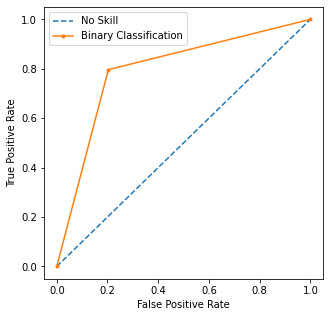

In [12]:
ns_probs = [0 for _ in range(len(labels))]
ns_auc = roc_auc_score(labels, ns_probs)
lr_auc = roc_auc_score(labels, pred)
print('Binary: ROC AUC=%.3f' % (lr_auc))
plt.figure(figsize=(5, 5))
ns_fpr, ns_tpr, th1 = roc_curve(labels, ns_probs)
lr_fpr, lr_tpr, th2 = roc_curve(labels, pred)
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Binary Classification')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show

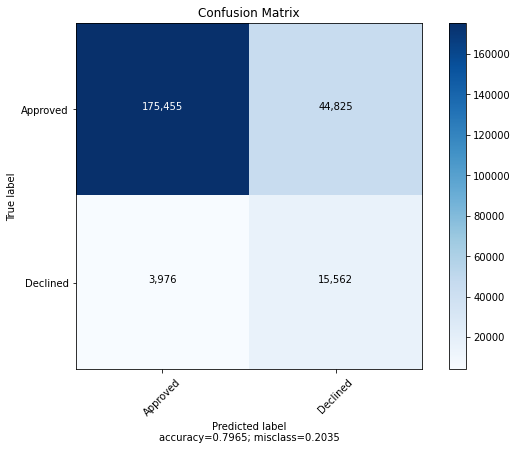

In [13]:
plot_confusion_matrix(cm, 
                      normalize    = False,
                      target_names = ['Approved', 'Declined'],
                      title        = "Confusion Matrix")

In [16]:
input_ = test[feats]
labels = test['TARGET']

pred = model.predict(input_)
th = find_optimal_cutoff(labels, pred)
pred = np.where(pred > th, 1, 0)
cm = confusion_matrix(labels, pred)

In [17]:
cr = classification_report(labels, pred, target_names=['Approved', 'Declined'])
print(cr)

              precision    recall  f1-score   support

    Approved       0.97      0.72      0.83     24453
    Declined       0.19      0.72      0.30      2194

    accuracy                           0.72     26647
   macro avg       0.58      0.72      0.56     26647
weighted avg       0.90      0.72      0.78     26647



Binary: ROC AUC=0.722


<function matplotlib.pyplot.show(close=None, block=None)>

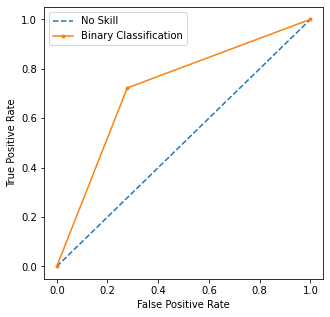

In [18]:
ns_probs = [0 for _ in range(len(labels))]
ns_auc = roc_auc_score(labels, ns_probs)
lr_auc = roc_auc_score(labels, pred)
print('Binary: ROC AUC=%.3f' % (lr_auc))
plt.figure(figsize=(5, 5))
ns_fpr, ns_tpr, th1 = roc_curve(labels, ns_probs)
lr_fpr, lr_tpr, th2 = roc_curve(labels, pred)
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Binary Classification')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show

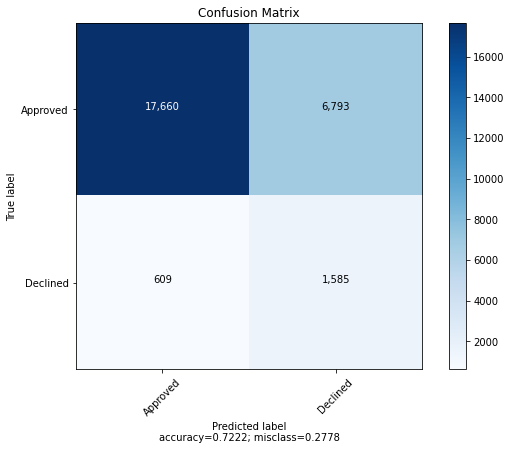

In [19]:
plot_confusion_matrix(cm, 
                      normalize    = False,
                      target_names = ['Approved', 'Declined'],
                      title        = "Confusion Matrix")